<div style="float:right">
    <table>
    <tr>
        <td> <img src="figs/kcl_logo.png" alt="Drawing" style="width:54px;height:40px;"/> 
        <td> <img src="figs/nceo_logo.png" alt="Drawing" style="width:200px;height:40px;"/> 
        <td> <img src="figs/multiply_logo.png" alt="Drawing" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>

# GPs as regressors for biophyiscal parameter inversion

**Author:** Jose Gómez-Dans (NCEO & UCL)  `jose.gomez-dans@kcl.ac.uk`


## Introduction
GPs are a general regression technique, and can be used to regress some wanted magnitude from a set of inputs. This isn’t as cool as other things you can do with them, but it’s feasible to do… GPs are flexible for regression and interpolation, but given that this library has a strong remote sensing orientation, we’ll consider their use for bionpysical parameter extraction from Sentinel-2 data (for example).


## Retrieving bionpysical parameters for Sentinel-2

Let’s assume that we want to retrieve leaf area index (LAI) from Sentinel-2 surface reflectance data. The regression problem can be stated as one where the inputs to the regressor are the spectral measurements of a pixel, and the output is the retrieved LAI. We can do this mapping by pairing in situ measurements, or we can just use a standard RT model to provide the direct mapping, and then learn the inverse mapping using the GP.

Although the problem is easy, we know that other parameters will have an effect in the measuremed reflectance, so we can only expect this to work over a limited spread of parameters other than LAI. Here, we show how to use the gp_emulator helper functions to create a suitable training set, and perform this.



After 15, the minimum cost was 1.317351e+02


Text(0.5, 1.0, 'Slope=  0.9737, Intercept=  0.0874, $R^2$=   0.975')

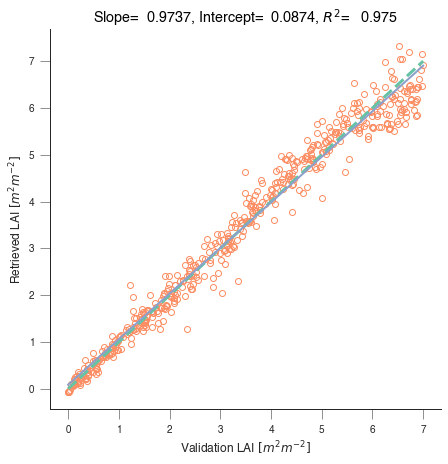

In [2]:
import numpy as np

import scipy.stats

import gp_emulator
import prosail

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)
# Define number of training and validation samples
n_train = 200
n_validate = 500
# Define the parameters and their spread
parameters = ["n", "cab", "car", "cbrown", "cw", "cm", "lai", "ala"]
p_mins =     [1.6, 25,    5,     0.0,     0.01, 0.01, 0.,   32.]
p_maxs =     [2.1, 90,    20,    0.4,     0.014, 0.016, 7.,   57.]

# Create the training samples
training_samples, distributions = gp_emulator.create_training_set(parameters, p_mins, p_maxs,
                        n_train=n_train)
# Create the validation samples
validation_samples = gp_emulator.create_validation_set(distributions, n_validate=n_validate)

# Load up the spectral response functions for S2
srf = np.loadtxt("S2A_SRS.csv", skiprows=1,
                delimiter=",")[100:, :]
srf[:, 1:] = srf[:, 1:]/np.sum(srf[:, 1:], axis=0)
srf_land = srf[:, [ 2, 3, 4, 5, 6, 7, 8, 9, 12, 13]].T

# Generate the reflectance training set by running the RT model
# for each entry in the training set, and then applying the
# spectral basis functions.
training_s2 = np.zeros((n_train, 10))
for i, p in enumerate(training_samples):
    refl = prosail.run_prosail (p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7],
                                0.001, 30., 0, 0, prospect_version="D",
                                rsoil=0., psoil=0, rsoil0=np.zeros(2101))
    training_s2[i, :] = np.sum(refl*srf_land, axis=-1)

# Generate the reflectance validation set by running the RT model
# for each entry in the validation set, and then applying the
# spectral basis functions.
validation_s2 = np.zeros((n_validate, 10))
for i, p in enumerate(validation_samples):
    refl = prosail.run_prosail (p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7],
                                0.001, 30., 0, 0, prospect_version="D",
                                rsoil=0., psoil=0, rsoil0=np.zeros(2101))
    validation_s2[i, :] = np.sum(refl*srf_land, axis=-1)

# Define and train the emulator from reflectance to LAI
gp = gp_emulator.GaussianProcess(inputs=training_s2, targets=training_samples[:, 6])
gp.learn_hyperparameters(n_tries=15, verbose=False)

# Predict the LAI from the reflectance
ypred, _, _ = gp.predict(validation_s2)

# Plot
fig = plt.figure(figsize=(7,7))
plt.plot(validation_samples[:, 6], ypred, 'o', mfc="none")
plt.plot([p_mins[6], p_maxs[6]], [p_mins[6], p_maxs[6]],
        '--', lw=3)
x = np.linspace(p_mins[6], p_maxs[6], 100)

regress = scipy.stats.linregress(validation_samples[:, 6], ypred)
plt.plot(x, regress.slope*x + regress.intercept, '-')
plt.xlabel(r"Validation LAI $[m^{2}m^{-2}]$")
plt.ylabel(r"Retrieved LAI $[m^{2}m^{-2}]$")
plt.title("Slope=%8.4f, "%(regress.slope) +
          "Intercept=%8.4f, "%(regress.intercept) +
          "$R^2$=%8.3f" % (regress.rvalue**2))

The results are quite satisfactory. Another issue is whether these results will work as well on real Sentinel-2 data of random vegetation classes!!! One reason why they won’t is because above I have assumed the soil to be black. While this won’t matter for situations with large canopy cover, it will for low LAI.

## Final remarks

GPs are just a type of regressor or interpolator. The ability to map from one space (e.g. reflectance) to another (parameters) can in this case be thought of *learning* the transfer function by being presented pairs of inputs and outputs. Given a flexible enough template function (in this case, a GP, but neural nets, SVR, RF, etc. are also options), and enough training data, then we can approximate the underlying function. We can see that GPs tend to do this quite efficiently with just a few hundred samples (ANNs will tend to use tens of thousands of samples), but we also have to understand that these methods have not taken into consideration the following 

1. The uncertainties in the data
2. The shortcomings in the physical model (PROSAIL in this case)
3. Any other complexity arising from incompatibilities in the scene and in the model assumptions.

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.